In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from ase.io import read

# Set global matplotlib rc parameters for better readability
plt.rcParams.update({
    'font.size': 14,           # Increase the font size
    'font.weight': 'bold',     # Make the font bold
    'axes.labelsize': 16,      # Axis label size
    'axes.titlesize': 18,      # Title size
    'axes.labelweight': 'bold',  # Bold axis labels
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'xtick.major.width': 1.2,  # X-axis major tick width
    'ytick.major.width': 1.2,  # Y-axis major tick width
    'axes.linewidth': 1.5,     # Axis line width
})

### Helper functions

In [13]:
def find_peak(E, T, xlim):
    mask = (E >= xlim[0]) & (E <= xlim[1])
    if np.any(mask):
        max_idx = np.argmax(T[mask])
        peak_height = T[mask][max_idx]
        peak_position = E[mask][max_idx]
        return peak_position, peak_height
    else:
        return None, None

def plot_atomic_positions_with_occupancy(atoms, element_colors, occupancy,title):

    fig, ax = plt.subplots(figsize=(10, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    occupancy_index = 0
    for i, (xi, yi, atom) in enumerate(zip(x, y, atoms)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


        if atom.symbol in ['C', 'N']:
            ax.text(
                xi + 0.2, yi,
                f"{occupancy[occupancy_index]:.2f}",
                color='blue', fontsize=9, ha='left', va='center'
            )
            occupancy_index += 1

    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title(title)

    plt.show()


In [14]:
def create_index_to_atom_mapping(atoms):
    """
    Create a mapping of element symbols to their indices in the  list.

    Args:
        atoms: ASE Atoms object containing the atomic structure.
        : List of quantities corresponding to C and N atoms in the same order.

    Returns:
        dict: A dictionary mapping element symbols ('C', 'N') to their  indices.
    """
    mapping = {}
    index = 0

    for atom in atoms:
        if atom.symbol in ['C', 'N']:
            if atom.symbol not in mapping:
                mapping[atom.symbol] = []
            mapping[atom.symbol].append(index)
            index += 1

    return mapping


In [15]:
atoms = read('dft/device/scatt.xyz')
filtered_atoms = atoms[[atom.symbol not in ['H', 'Au'] for atom in atoms]]
element_colors = {'C': 'cyan', 'N': 'green'}
mapping = create_index_to_atom_mapping(filtered_atoms)
print(mapping)


{'N': [0, 8], 'C': [1, 2, 3, 4, 5, 6, 7]}


In [16]:
data_folder = "output/lowdin"
eigvals_bare = np.load(f"{data_folder}/eigvals_Hbare.npy")
eigvals_eff = np.load(f"{data_folder}/eigvals_Heff.npy")
_,T = np.load(f"{data_folder}/dft_transmission.npy")
dos = np.load(f"{data_folder}/dft_dos.npy")
Eref, Tref_dft = np.load("reference/ET_dft.npy")
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)

In [17]:
occupancies = np.load(f"{data_folder}/occupancies.npy")
total_occupancy = np.sum(occupancies)
total_occupancy

10.787299188461565

Text(0.5, 0, 'Energy (eV)')

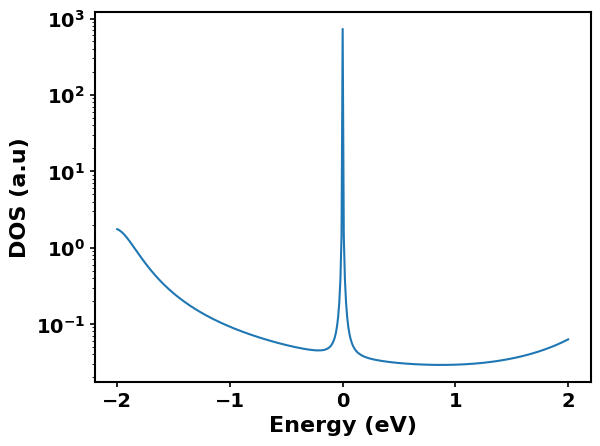

In [18]:
dmft_gfloc = np.load("output/lowdin/U_0/dmft_gfloc.npy")
dos = -1 / np.pi * dmft_gfloc.sum(axis=0).imag
plt.plot(energies,dos)
plt.plot()
plt.yscale("log")
plt.ylabel("DOS (a.u)")
plt.xlabel("Energy (eV)")

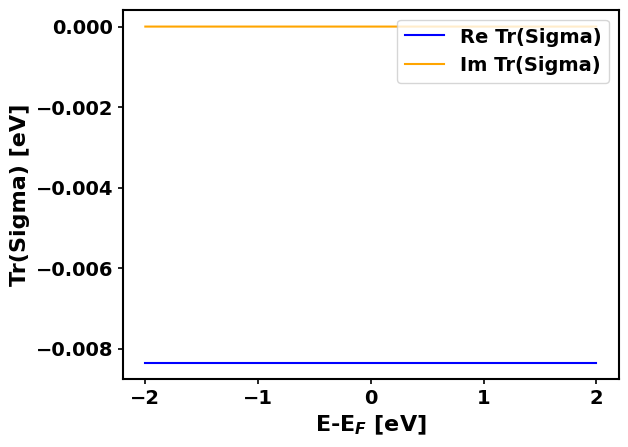

In [19]:
sigma = np.load("output/lowdin/U_0/dmft_sigma.npy")
sigma.shape
trace_sigma = np.trace(sigma, axis1=1, axis2=2)
plt.plot(energies, trace_sigma.real, label="Re Tr(Sigma)", color="blue")
plt.plot(energies, trace_sigma.imag, label="Im Tr(Sigma)", color="orange")

plt.xlabel("E-E$_F$ [eV]")
plt.ylabel("Tr(Sigma) [eV]")
plt.legend(loc="upper right")

/home/anooja/miniconda3/envs/guido-edpyt-qtpyt/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/anooja/miniconda3/envs/guido-edpyt-qtpyt/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Energy (eV)')

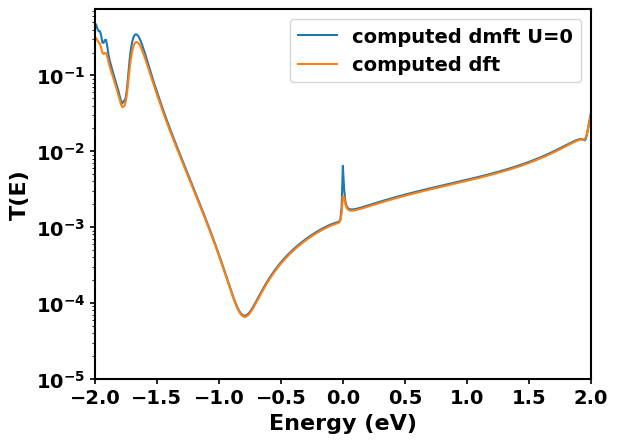

In [20]:
energies, dmft_transmission = np.load("output/lowdin/U_0/dmft_transmission.npy")
plt.plot(energies,dmft_transmission,label="computed dmft U=0")
plt.plot(energies,T,label="computed dft")
plt.yscale("log")
plt.legend()
plt.xlim(-2,2)
plt.ylim(bottom=1e-5)
plt.ylabel("T(E)")
plt.xlabel("Energy (eV)")

### U = 4

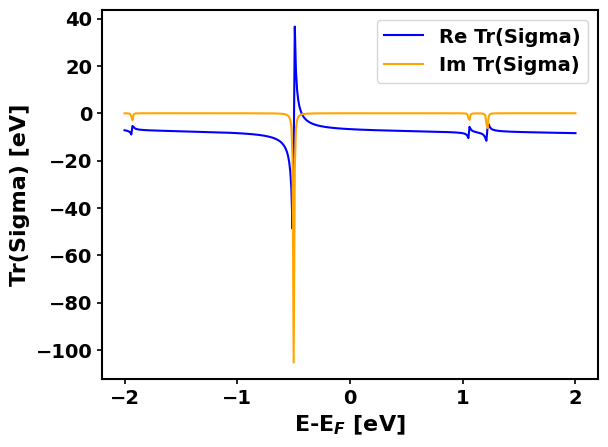

In [21]:
sigma = np.load("output/lowdin/U_4/tol_1e-4/dmft_sigma.npy")
trace_sigma = np.trace(sigma, axis1=1, axis2=2)
plt.plot(energies, trace_sigma.real, label="Re Tr(Sigma)", color="blue")
plt.plot(energies, trace_sigma.imag, label="Im Tr(Sigma)", color="orange")

plt.xlabel("E-E$_F$ [eV]")
plt.ylabel("Tr(Sigma) [eV]")
plt.legend(loc="upper right")

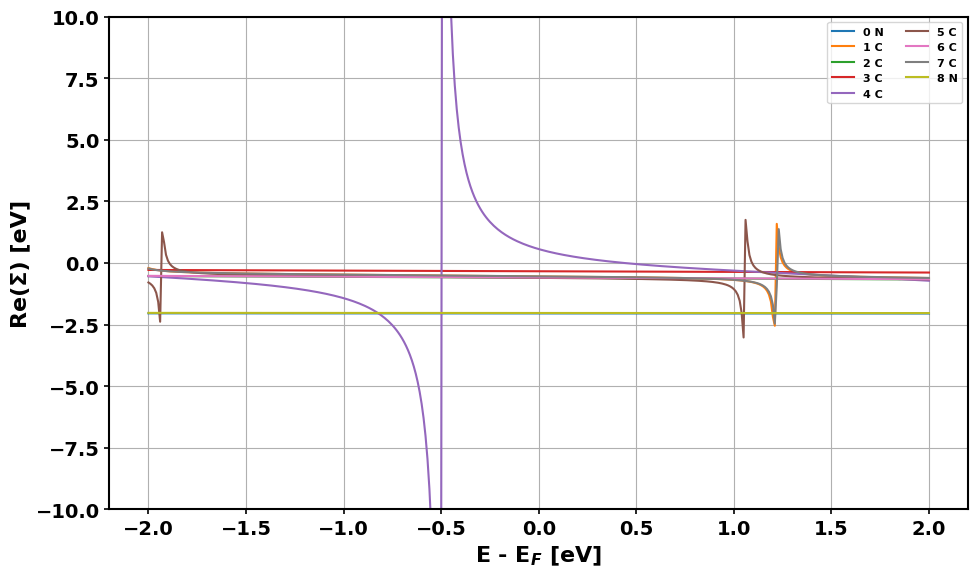

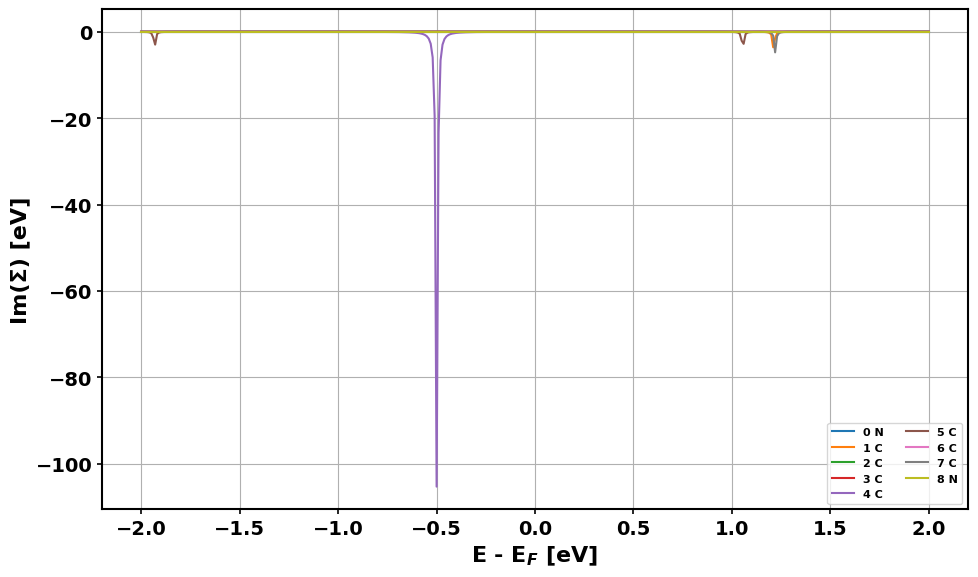

In [49]:
plt.figure(figsize=(10, 6))
# indices = [5]
for index, atom_symbol in enumerate(filtered_atoms):
    diagonal_sigma = sigma[:, index, index]
    plt.plot(
        energies,
        diagonal_sigma.real,
        label=f"{index} {atom_symbol.symbol}",
        linestyle="-"
    )
plt.xlabel("E - E$_F$ [eV]")
plt.ylabel("Re(Σ) [eV]")
plt.ylim(-10, 10)
plt.legend(loc="upper right", fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for index, atom_symbol in enumerate(filtered_atoms):
    diagonal_sigma = sigma[:, index, index]
    plt.plot(
        energies,
        diagonal_sigma.imag,
        label=f"{index} {atom_symbol.symbol}",
        linestyle="-"
    )

plt.xlabel("E - E$_F$ [eV]")
plt.ylabel("Im(Σ) [eV]")
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

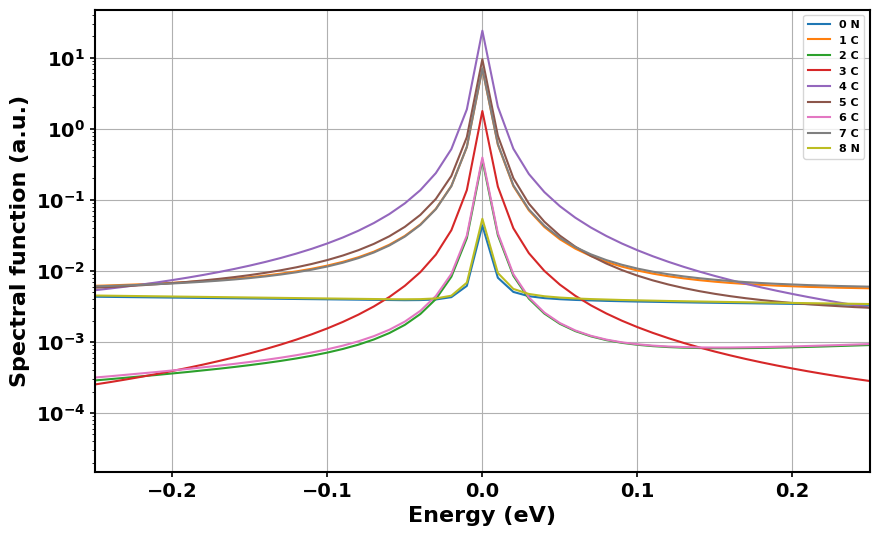

In [64]:
dmft_gfloc = np.load("output/lowdin/U_4/tol_1e-4/dmft_gfloc.npy")
plt.figure(figsize=(10, 6))
for index, atom_symbol in enumerate(filtered_atoms):
    dos = -1 / np.pi * dmft_gfloc[index, :].imag
    plt.plot(energies, dos, label=f"{index} {atom_symbol.symbol}")

plt.yscale("log")
plt.ylabel("Spectral function (a.u.)")
plt.xlabel("Energy (eV)")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True)
plt.xlim(-0.25, 0.25)
plt.show()

Text(0.5, 0, 'Energy (eV)')

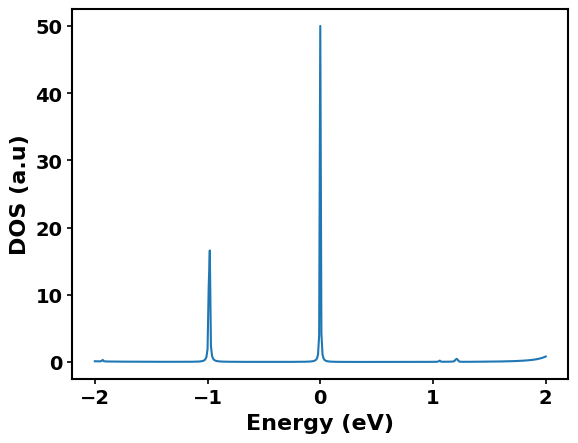

In [57]:
dmft_gfloc = np.load("output/lowdin/U_4/tol_1e-4/dmft_gfloc.npy")
dos = -1 / np.pi * dmft_gfloc.sum(axis=0).imag
plt.plot(energies,dos)
plt.plot()
# plt.yscale("log")
plt.ylabel("DOS (a.u)")
plt.xlabel("Energy (eV)")

Text(0.5, 0, 'Energy (eV)')

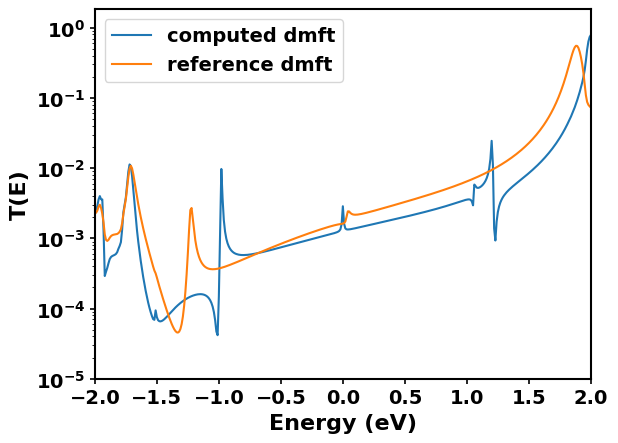

In [9]:
Eref,reference_dmft = np.load("reference/ET_dmft.npy")
energies, dmft_transmission = np.load("output/lowdin/U_4/tol_1e-4/dmft_transmission.npy")
plt.plot(energies,dmft_transmission,label="computed dmft")
plt.plot(Eref,reference_dmft,label="reference dmft")
plt.yscale("log")
plt.legend()
plt.xlim(-2,2)
plt.ylim(bottom=1e-5)
plt.ylabel("T(E)")
plt.xlabel("Energy (eV)")

Text(0.5, 0, 'Energy (eV)')

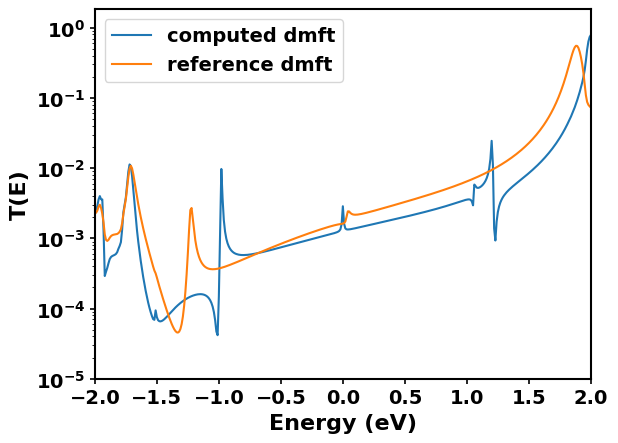

In [14]:
Eref,reference_dmft = np.load("reference/ET_dmft.npy")
energies, dmft_transmission = np.load("output/lowdin/U_4/tol_1e-6/dmft_transmission.npy")
plt.plot(energies,dmft_transmission,label="computed dmft")
plt.plot(Eref,reference_dmft,label="reference dmft")
plt.yscale("log")
plt.legend()
plt.xlim(-2,2)
plt.ylim(bottom=1e-5)
plt.ylabel("T(E)")
plt.xlabel("Energy (eV)")